[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture5_noise_stability.ipynb)

# Lecture 5: Noise Stability & Arrow's Theorem

**Topics**: Noise Operator, Noise Stability, Isoperimetric Inequalities, Arrow's Theorem

**O'Donnell Chapters**: 2.4-2.5  
**Based on lecture notes by: Prastik Mohanraj**  
**Notebook by: Gabriel Taboada**

---

## Key Concepts

1. **Noise Operator**: $T_\rho f(x) = \mathbb{E}_{y \sim N_\rho(x)}[f(y)]$
2. **Noise Stability**: $\text{Stab}_\rho[f] = \langle f, T_\rho f \rangle$
3. **Fourier Formula**: $\text{Stab}_\rho[f] = \sum_S \rho^{|S|} \hat{f}(S)^2$
4. **Arrow's Theorem**: Dictator is the only "stable" voting rule

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


BooFun version: 1.1.1


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis import SpectralAnalyzer
from boofun.visualization import BooleanFunctionVisualizer

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 5)

## 1. The Noise Operator

**Definition**: The noise operator $T_\rho$ averages $f$ over noisy versions of the input:

$$T_\rho f(x) = \mathbb{E}_{y \sim N_\rho(x)}[f(y)]$$

where $N_\rho(x)$ independently: keeps each bit with probability $\frac{1+\rho}{2}$, flips with probability $\frac{1-\rho}{2}$.

**Key result** (Fourier domain): $\widehat{T_\rho f}(S) = \rho^{|S|} \hat{f}(S)$

**Interpretation**: Noise *damps higher-frequency components* exponentially in their degree:
- Low-degree terms ($|S|$ small): $\rho^{|S|} \approx 1$ → survive noise
- High-degree terms ($|S|$ large): $\rho^{|S|} \approx 0$ → destroyed by noise

This is analogous to a low-pass filter in signal processing.

In [3]:
# Demonstrate how noise damps Fourier coefficients by degree
n = 5
rho = 0.7  # moderate noise

functions = {
    "Majority": bf.majority(n),
    "Parity": bf.parity(n),
    "Dictator x₀": bf.dictator(n, 0),
}

print(f"Effect of noise (ρ={rho}) on Fourier coefficients:")
print("=" * 60)
print(f"{'Function':<15} {'|S|':<5} {'f̂(S)':<10} {'ρ^|S|':<10} {'After noise'}")
print("-" * 60)

for name, f in functions.items():
    fourier = f.fourier()
    # Find largest non-zero coefficients
    for s in range(len(fourier)):
        if abs(fourier[s]) > 0.01:
            degree = bin(s).count('1')
            damping = rho ** degree
            after = fourier[s] * damping
            print(f"{name:<15} {degree:<5} {fourier[s]:<10.4f} {damping:<10.4f} {after:.4f}")
    print()

print("Key insight: Parity (degree-n) is destroyed by noise, dictator (degree-1) survives.")

Effect of noise (ρ=0.7) on Fourier coefficients:
Function        |S|   f̂(S)      ρ^|S|      After noise
------------------------------------------------------------
Majority        1     0.3750     0.7000     0.2625
Majority        1     0.3750     0.7000     0.2625
Majority        1     0.3750     0.7000     0.2625
Majority        3     -0.1250    0.3430     -0.0429
Majority        1     0.3750     0.7000     0.2625
Majority        3     -0.1250    0.3430     -0.0429
Majority        3     -0.1250    0.3430     -0.0429
Majority        3     -0.1250    0.3430     -0.0429
Majority        1     0.3750     0.7000     0.2625
Majority        3     -0.1250    0.3430     -0.0429
Majority        3     -0.1250    0.3430     -0.0429
Majority        3     -0.1250    0.3430     -0.0429
Majority        3     -0.1250    0.3430     -0.0429
Majority        3     -0.1250    0.3430     -0.0429
Majority        3     -0.1250    0.3430     -0.0429
Majority        5     0.3750     0.1681     0.0630

Parity 

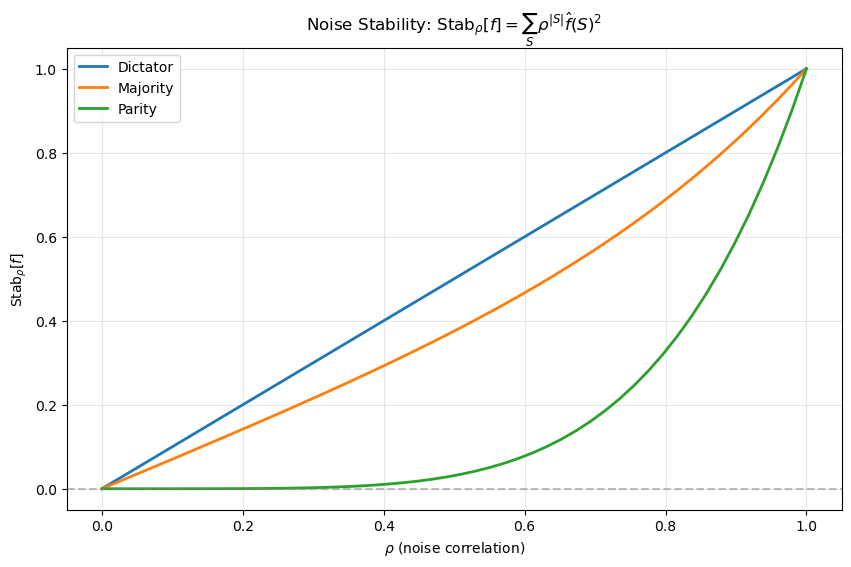

Why the curves differ:
  Dictator:  Weight on degree 1 → ρ^1 damping (slow)
  Majority:  Weight spread across odd degrees → moderate damping
  Parity:    All weight on degree n=5 → ρ^5 damping (fast)


In [4]:
# Compare noise stability across different functions
n = 5
rhos = np.linspace(0, 1, 50)

functions = {
    "Dictator": bf.dictator(n, 0),
    "Majority": bf.majority(n),
    "Parity": bf.parity(n),
}

plt.figure(figsize=(10, 6))
for name, f in functions.items():
    analyzer = SpectralAnalyzer(f)
    stabilities = [analyzer.noise_stability(rho) for rho in rhos]
    plt.plot(rhos, stabilities, label=name, linewidth=2)

plt.xlabel(r'$\rho$ (noise correlation)')
plt.ylabel(r'$\text{Stab}_\rho[f]$')
plt.title('Noise Stability: $\\text{Stab}_\\rho[f] = \\sum_S \\rho^{|S|} \\hat{f}(S)^2$')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.show()

print("Why the curves differ:")
print("  Dictator:  Weight on degree 1 → ρ^1 damping (slow)")
print("  Majority:  Weight spread across odd degrees → moderate damping")
print("  Parity:    All weight on degree n=5 → ρ^5 damping (fast)")

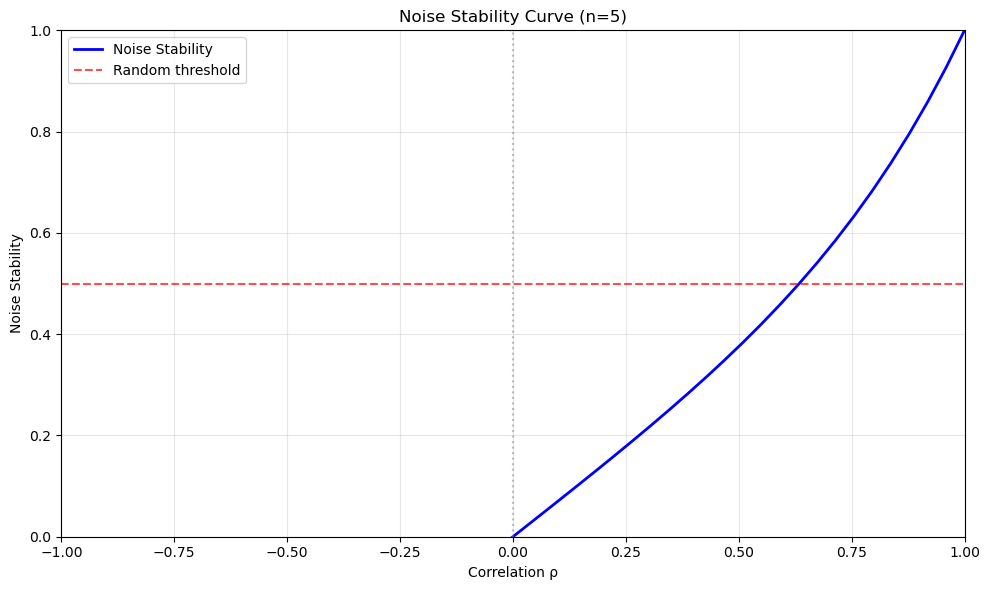

The noise stability curve shows how the function responds to noise.
  - ρ=1: Perfect correlation (Stab=1)
  - ρ=0: Independent inputs (Stab=E[f]²)
  - ρ=-1: Perfectly anti-correlated


In [5]:
# Use the built-in noise stability visualization
maj = bf.majority(5)
viz = BooleanFunctionVisualizer(maj)

# Plot noise stability curve for a single function
fig = viz.plot_noise_stability_curve(figsize=(10, 6), show=True)

print("The noise stability curve shows how the function responds to noise.")
print("  - ρ=1: Perfect correlation (Stab=1)")
print("  - ρ=0: Independent inputs (Stab=E[f]²)")
print("  - ρ=-1: Perfectly anti-correlated")

## 2. Noise Stability and Voting

**Definition**: $\text{Stab}_\rho[f] = \langle f, T_\rho f \rangle = \Pr_{x, y \sim N_\rho(x)}[f(x) = f(y)]$ (in $\pm 1$)

**Fourier formula**: $\text{Stab}_\rho[f] = \sum_S \rho^{|S|} \hat{f}(S)^2$

**Voting interpretation**: If voters are *slightly noisy* (each flips their vote with small probability), how often does the outcome change?
- High stability → robust to noise (good)
- Low stability → sensitive to noise (bad)

## 3. Arrow's Theorem via Noise Stability

**Setup**: Consider voting rules $f: \{0,1\}^n \to \{0,1\}$ that are:
- **Unanimous**: $f(0,\ldots,0) = 0$ and $f(1,\ldots,1) = 1$ (if everyone agrees, so does the outcome)
- **Monotone**: Changing a vote from 0 to 1 can only help outcome 1
- **Odd/Balanced**: $\mathbb{E}[f] = 1/2$ (neither outcome is favored a priori)

**Arrow's Theorem** (Fourier version): Among such functions, dictators are uniquely the *most noise-stable*.

**Quantitative version**: If $f$ is $\epsilon$-far from any dictator, then 
$$\text{Stab}_{1-\delta}[f] \leq 1 - \Omega(\epsilon \delta)$$

**Implication**: Any "fair" voting rule (non-dictatorial) must be somewhat sensitive to noise.

In [6]:
# Verify Arrow's theorem empirically: dictator is most stable among voting rules
n = 5
rho = 0.9  # high correlation (small noise)

voting_rules = {
    "Dictator x₀": bf.dictator(n, 0),
    "Majority": bf.majority(n),
    "Threshold-2": bf.threshold(n, 2),  # at least 2 votes
}

print(f"Noise stability at ρ={rho} (higher = more stable):")
print("=" * 50)

stabilities = []
for name, f in voting_rules.items():
    analyzer = SpectralAnalyzer(f)
    stab = analyzer.noise_stability(rho)
    stabilities.append((stab, name))
    print(f"  {name:<15}: Stab_{rho}[f] = {stab:.4f}")

print()
best = max(stabilities)[1]
print(f"Most stable: {best}")
print("(Arrow's theorem: dictator is uniquely optimal among balanced monotone rules)")

Noise stability at ρ=0.9 (higher = more stable):
  Dictator x₀    : Stab_0.9[f] = 0.9000
  Majority       : Stab_0.9[f] = 0.8298
  Threshold-2    : Stab_0.9[f] = 0.8866

Most stable: Dictator x₀
(Arrow's theorem: dictator is uniquely optimal among balanced monotone rules)


## Summary

### Key Formulas

| Concept | Formula |
|---------|---------|
| Noise operator | $T_\rho f(x) = \mathbb{E}_{y \sim N_\rho(x)}[f(y)]$ |
| Fourier effect | $\widehat{T_\rho f}(S) = \rho^{|S|} \hat{f}(S)$ |
| Noise stability | $\text{Stab}_\rho[f] = \sum_S \rho^{|S|} \hat{f}(S)^2$ |

### Key Insights

1. **Low-pass filter**: Noise damps high-degree Fourier coefficients exponentially
2. **Low-degree = Stable**: Functions with weight on small $|S|$ are noise-stable
3. **Arrow's Theorem**: Among balanced monotone voting rules, dictators are uniquely optimal for stability

### boofun Usage

```python
analyzer = SpectralAnalyzer(f)
stability = analyzer.noise_stability(rho)  # Stab_ρ[f]
```